#Visualise training

In [2]:
import sys
sys.path.append('../models/attention/')

import matplotlib.pyplot as plt
import cPickle as pkl
import seaborn as sb
from collections import OrderedDict

models_dir = '/media/Data/flipvanrijn/models/'
models = OrderedDict()
models['Baseline'] = 'baseline'
models['Raw context'] = 'context_att_raw'
models['TF-IDF']   = 'context_att_tfidf'
models['TF-IDF w/o stemming'] = 'context_att_tfidf_wo_stemming'
models['TF-IDF w/o LSA'] = 'context_att_tfidf_wo_lsa'
models['W2V n=1']  = 'context_att_w2v1ngram'
models['W2V n=2']  = 'context_att_w2v2ngram'
models['W2V n=3']  = 'context_att_w2v3ngram'
models['W2V & TF-IDF'] = 'context_att_w2vtfidf'

errors_val = []
errors_test = []

for model in models.values():
    with open('{}{}.npz.pkl'.format(models_dir, model)) as f:
        opts = pkl.load(f)
    monitor = opts['monitor']
    errors_val.append([x[0] for x in monitor.history_errors])
    errors_test.append([x[1] for x in monitor.history_errors])

In [4]:
plt.rcParams.update({'font.size': 12})
pal = sb.color_palette('hls', n_colors=9)
sb.set_palette(pal, n_colors=9)

fig = plt.figure()
# Validation errors
for errors in errors_val:
    plt.plot(errors)
plt.legend(models.keys())
plt.xlabel('Epochs')
plt.ylabel('Log loss')
plt.title('Validation log loss')
plt.savefig('/home/flipvanrijn/plots/log-loss-val.pdf', dpi=1000)

fig = plt.figure()
# Test errors
for errors in errors_test:
    plt.plot(errors)
plt.legend(models.keys())
plt.xlabel('Epochs')
plt.ylabel('Log loss')
plt.title('Test log loss')
plt.savefig('/home/flipvanrijn/plots/log-loss-test.pdf', dpi=1000)

#Run model

In [178]:
import re
import numpy as np
import time
base_path = '/media/Data/flipvanrijn/datasets/coco/processed/reduced/'

In [5]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize

print 'Loading word2vec model...'
t_model_start = time.time()
w2vmodel = Word2Vec.load_word2vec_format('/media/Data/flipvanrijn/models/word2vec/enwiki-latest-pages.512.bin', binary=True)
print 'Loaded in {}s'.format(time.time() - t_model_start)

Couldn't import dot_parser, loading of dot files will not be possible.
Loading word2vec model...
Loaded in 44.1783490181s


Using gpu device 0: Quadro K2200


In [6]:
from itertools import islice

def ngrams(title, description, tags, n = 2):
    global w2vmodel 
    
    def window(seq, n=2):
        "Returns a sliding window (of width n) over data from the iterable"
        "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
        it = iter(seq)
        result = tuple(islice(it, n))
        if len(result) < n:
            yield result
        if len(result) == n:
            yield result    
        for elem in it:
            result = result[1:] + (elem,)
            yield result

    def preprocess(s, w2vmodel):        
        ns = []
        for w in s:
            if w and w in w2vmodel:
                ns.append(w)
        
        return ns
    
    context = []
    title = preprocess(title.split(' '), w2vmodel)
    if title:
        context.append(title)
    # ... description (for each sentence) ...
    for desc in sent_tokenize(description):
        desc = preprocess(desc.split(' '), w2vmodel)
        if desc:
            context.append(desc)
    # ... and tagsc
    ts = preprocess(tags, w2vmodel)
    if ts:
        context.append(ts)

    X = []
    if context:
        for sent in context:
            X += [' '.join(x) for x in window(sent, n)]
    
    return X

def recvall(sock, n):
    data = ''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

def recv_msg(sock):
    raw_length = recvall(sock, 4)
    if not raw_length:
        return None
    length = struct.unpack('>I', raw_length)[0]
    return recvall(sock, length)

In [7]:
featdict = OrderedDict()
idx = 0
#with open(base_path+'train2014list.txt', 'r') as f: #    ls train > train2014list.txt
#    for line in f:
#        line = re.sub(r'\/.*\/','',line).strip()
#        featdict[line] = idx
#        idx += 1
with open(base_path+'val2014list.txt', 'r') as f: #    ls val > val2014list.txt
    for line in f:
        line = re.sub(r'\/.*\/','',line).strip()
        featdict[line] = idx
        idx += 1
split = []
with open(base_path+'splits/coco_val.txt', 'r') as f:
    for idx, line in enumerate(f):
        split.append(line.strip())

In [825]:
# load data
model_type = 'tfidf_wo_lsa'
with open(base_path+'/'+model_type+'/coco_align.dev.pkl', 'r') as f:
    data_cap = pkl.load(f)
    data_img = pkl.load(f)
    data_ctx = pkl.load(f)

In [151]:
with open(base_path+'coco_val_context.pkl') as f:
    titles = pkl.load(f)
    descriptions = pkl.load(f)
    tags = pkl.load(f)

import matplotlib.pyplot as plt
plt.imshow(data_img[index].todense().reshape((196, 512)))
plt.show()

Index 816
Image COCO_val2014_000000473299.jpg
ski trip ski trip in new hampshire at mount sunnapee . 2011 35mm canonet giii negatives rangefinder ski skiing snow snowboard mountain fun country nature trees hill winter ride201135mmcanonetgiiinegativesrangefinder


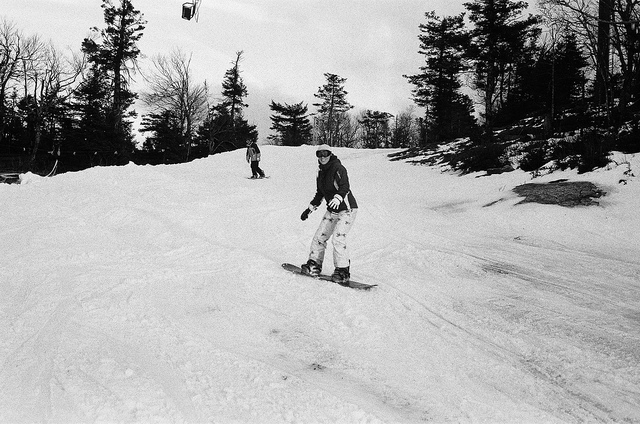

In [1011]:
index = 816#3901#random.randint(0, len(split))
print 'Index', index
image_file = split[index]
print 'Image', image_file
image_path = '/media/Data/flipvanrijn/datasets/coco/images/val/'+image_file
img = Image.open(image_path)
ctx_idx = featdict[split[index]]
context = titles[ctx_idx] + ' ' + descriptions[ctx_idx] + ' ' + ' '.join(tags[ctx_idx])
print context
img

In [1063]:
context_shape = data_ctx[index].shape
server_data = {
    'img': {
        'pixels': img.tobytes(), 
        'size': img.size, 
        'mode': img.mode, 
    },
    'introspect_context': True, 
    'introspect_image': False, 
    'output_path': '/home/flipvanrijn/plots/out.png',
    'text': 'snonwboard snowboarding trip in new hampshire at mount sunnapee . 2011 35mm canonet giii negatives rangefinder snow snowboard mountain fun country nature trees hill winter ride201135mmcanonetgiiinegativesrangefinder',
}
server_data = pkl.dumps(server_data)

In [1064]:
import socket, struct
HOST, PORT = "localhost", 9999
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
try:
    # Connect to server and send data
    sock.connect((HOST, PORT))
    server_data = struct.pack('>I', len(server_data)) + server_data
    sock.sendall(server_data)

    # Receive data from the server and shut down
    response = pkl.loads(recv_msg(sock))
finally:
    sock.close()
print response['captions'][0]

a man riding skis down a snow covered slope .


#Visualize model

###W2V

In [1065]:
# N-gram setting
n = 2

ctx_idx = featdict[split[index]]
ngrams_list = ngrams(titles[ctx_idx], descriptions[ctx_idx], tags[ctx_idx], n=n)
tau_idx = 0
scores = []
words = []
#for idx, score in zip(np.argsort(response['tau'][tau_idx])[0], np.sort(response['tau'][tau_idx])[0])[::-1]:
for idx, score in enumerate(response['tau'][tau_idx][0]):
    if idx < len(ngrams_list):
        words.append(ngrams_list[idx])
        scores.append(score)
norm_scores = [float(x)/max(scores) for x in scores]
plt.plot(norm_scores)
for i, (word, score) in enumerate(zip(words, norm_scores)):
    plt.text(i, score, word, {'ha': 'center', 'va': 'center'}, rotation=-25,)
plt.xlabel('N-gram')
plt.ylabel('Attention activation', labelpad=20)
plt.savefig('/home/flipvanrijn/plots/w2v{}gram-{}-alt.pdf'.format(n, index))
plt.close()

### TFIDF

In [1016]:
import matplotlib.patches as patches
from collections import Counter
import operator

data = response['tau'][1][0].tolist()
data_maxes = np.where(np.array(data) > 0.03) # Counter(np.array(data)).most_common(1)[0][0]
ticks = data_maxes[0].tolist()

fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')
newax = fig.add_axes([0.75, 0.05, 0.2, 0.2], anchor='SE')
newax.plot(data)
newax.xaxis.set_ticks(ticks)
newax.xaxis.set_ticklabels(ticks, rotation=40, ha='center')
newax.tick_params(direction='out', pad=0)
newax.yaxis.tick_right()
newax.set_ylim([0, 1])
fig.tight_layout()
plt.savefig('/home/flipvanrijn/plots/tfidf-{}-alt.pdf'.format(index))
plt.close()

#--------#

In [830]:
from colored import fg, bg
ctx_idx = featdict[split[index]]
ngrams_list = ngrams(titles[ctx_idx], descriptions[ctx_idx], tags[ctx_idx], n=2)
print ngrams_list

ngram_scores = OrderedDict(zip(np.argsort(response['tau'][0])[0], np.sort(response['tau'][0])[0]))

def traverse_ngrams(lst, scores_lst, pos_l, pos_w, scores=[]):
    if pos_w == 0 or pos_l == len(lst):
        # Ended up at the start of the ngram
        return np.sum(scores), pos_l, pos_w + 1

    # Continue to work forward in the list of ngrams
    pos_l += 1
    pos_w -= 1
    scores += [scores_lst[pos_l]]
    # Recurse
    return traverse_ngrams(lst, scores_lst, pos_w=pos_w, pos_l=pos_l, scores=scores)

def viz_word_scores(inpt):
    ''' 
    Prints a colored string of the raw context and their TF-IDF weights.
    Expects: inpt -> list of tuples [(word, score)]
    
    Old visualisation:
    colors = range(232, 255, 2)[::-1] # Color range from dark to light
    scores = [s[1] for s in inpt] # TF-IDF scores
    scores = scores / np.linalg.norm(scores)
    words = [s[0] for s in inpt] # Words
    bins = np.linspace(0, 1, len(colors)) # Bins for the range 0 to 1 
    pos = np.digitize(scores, bins) # The index of the bin for each score/word
    for w, p, s in zip(words, pos, scores):
        if s > 0:
            print('%s%s%s' % (fg(255), bg(colors[p]), w)),
        else:
            print('%s%s%s' % (fg('black'), bg(255), w)), # stopword/unknown word
    '''

pos_w = 0
pos_l = 0
word_scores = []
for i in range(len(ngrams_list) + 1):
    start_score = ngram_scores[pos_l]
    word = ngrams_list[pos_l].split(' ')[pos_w]
    score, pos_l, pos_w = traverse_ngrams(ngrams_list, ngram_scores, pos_w=pos_w, pos_l=pos_l, scores=[start_score])
    word_scores += [(word, score)]

print 'Caption: ', response['captions'][0]
words = [x[0] for x in word_scores]
scores = [x[1] for x in word_scores]

plt.plot(norm_scores)
plt.show()
#viz_word_scores(word_scores)

[u'dude on', u'on rollerskates', u'rollerskates killing', u'killing it', u'it burnside', u'burnside skate', u'skate park', u'sent from', u'from my', u'my stoopid', u'stoopid iphone', u'burnside portland', u'portland skatepark', u'skatepark skateboard', u'skateboard rollerskate']
Caption:  a person is standing in a hanger with a skateboard .


In [25]:
from gensim.models import Word2Vec
model = Word2Vec.load_word2vec_format('/media/Data/flipvanrijn/models/word2vec/enwiki-latest-pages.512.bin', binary=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Quadro K2200


In [26]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
from itertools import islice
stop = stopwords.words('english')
stemmer = SnowballStemmer('english')
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) < n:
        yield result
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def preprocess(s, model):
    global stop, stemmer
    
    ns = []
    for w in s:
        if w and w in model and w not in stop:
            w = stemmer.stem(w)
            ns.append(w)

    return ns